# MAPD-B Distribute Processing Project

### Lucia Depaoli: 2016960, Alessandro Fella: 2024285, Simone Mistrali: 2021119

# Analysis of Covid-19 papers

This distributed computing project will focus on the analysis of $1000$ papers about COVID-19, SARS-CoV-2 and related corona viruses. The dataset is a sub-sample of $1000$ items taken from the original dataset that is composed of more than $75000$ papers. This dataset is a part of real-world research on COVID-19 named COVID-19 Open Research Dataset Challenge (CORD-19). The research and related challenges are available on the dedicated page on Kaggle: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

# Introduction

For the purpose of this assignment, we have relied on CloudVeneto.

We have created a cluster using the $3$ machine available on the server. One machine is the `dask-scheduler`, the other $2$ are the `dask-worker`. 

In order to make the cluster working, the same Dask and Distributed version should be installed in every machine. Also, the Python's packages used should be the same.



We access the machine via `ssh`:

``` bash
ssh -t -L port:127.0.0.1:port username@gate.cloudveneto.it ssh -L port:127.0.0.1:port root@ip-machine
```

`username`, `ip-machine`, `port` need to be changed. In our case, we have the following ip-address:
- `10.67.22.115` first machine
- `10.67.22.202` second machine
- `10.67.22.125` third machine


## Internal connection

In order to create the cluster the three machine need to communicate and "see" each other without password request.

The three machines see each other out-of-the-box because they are in the same network (we need to open a gate to Cloud Veneto server in order to see them).

The main problem is the `ssh` connection, because this type of connection always ask for a password and Dask can not automatically satisfy this request. To overcome this we make all the machines "SSH known host", making the login password-less.
For each machine we create a SSH key using the command `ssh-keygen`, and copy it to all the other machines (include the machine itself) using the following command:

```bash
ssh-copy-id 10.67.22.{115,202,125}
```

So all the machines now can communicate each other without asking the password.

## Cluster creation

We access the first machine using `port-7000`:

``` bash
ssh -t -L 7000:127.0.0.1:7000 username@gate.cloudveneto.it ssh -L 7000:127.0.0.1:7000 root@10.67.22.115
```


Then we use `dask-ssh` to create the cluster. After the command we have to specify the ip-address of the machines used. The first one is used for the scheduler, the following for the workers. 
The output will show the port of the scheduler and the workers. In this case we have created a cluster with 3 workers.

``` bash
dask-ssh 10.67.22.115 10.67.22.202 10.67.22.125
```


Next step is to create a ssh tunnel for the dask dashboard, which usually is by default in the `port-8787`. This will make the dask dashboard visible at `localhost:8787`:

``` bash
ssh -t -L 8787:127.0.0.1:8787 username@gate.cloudveneto.it ssh -L 8787:127.0.0.1:8787 root@10.67.22.115
```


Then we need to connect to the cluster via Jupyter Notebook.

``` bash
jupyter notebook --ip 127.0.0.1 --port 7000 --no-browser --allow-root
```

Inside Jupyer Notebook, we start the cluster (specifying the scheduler address).

``` bash
Client("tcp://10.67.22.115:8786")
```

In [1]:
from dask.distributed import Client,LocalCluster,SSHCluster    

client=Client("tcp://10.67.22.115:8786")

In [2]:
import dask.bag as db
import numpy as np
import dask as d
import dask.dataframe as dd
import json as js
from nltk.corpus import stopwords
from nltk import word_tokenize
import os, re, io
import time
import glob as gl
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

/root/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/root/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict
/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecat

In [3]:
client

<Client: 'tcp://10.67.22.115:8786' processes=3 threads=12, memory=22.91 GiB>

All documents are structured in this way:

``` bash
{
    "paper_id": <str>,                      # 40-character sha1 of the PDF
    "metadata": {
        "title": <str>,
        "authors": [                        # list of author dicts, in order
            {
                "first": <str>,
                "middle": <list of str>,
                "last": <str>,
                "suffix": <str>,
                "affiliation": <dict>,
                "email": <str>
            },
            ...
        ],
        "abstract": [                       # list of paragraphs in the abstract
            {
                "text": <str>,
                "cite_spans": [             # list of character indices of inline citations
                                            # e.g. citation "[7]" occurs at positions 151-154 in "text"
                                            #      linked to bibliography entry BIBREF3
                    {
                        "start": 151,
                        "end": 154,
                        "text": "[7]",
                        "ref_id": "BIBREF3"
                    },
                    ...
                ],
                "ref_spans": <list of dicts similar to cite_spans>,     # e.g. inline reference to "Table 1"
                "section": "Abstract"
            },
            ...
        ],
        "body_text": [                      # list of paragraphs in full body
                                            # paragraph dicts look the same as above
            {
                "text": <str>,
                "cite_spans": [],
                "ref_spans": [],
                "eq_spans": [],
                "section": "Introduction"
            },
            ...
            {
                ...,
                "section": "Conclusion"
            }
        ],
        "bib_entries": {
            "BIBREF0": {
                "ref_id": <str>,
                "title": <str>,
                "authors": <list of dict>       # same structure as earlier,
                                                # but without `affiliation` or `email`
                "year": <int>,
                "venue": <str>,
                "volume": <str>,
                "issn": <str>,
                "pages": <str>,
                "other_ids": {
                    "DOI": [
                        <str>
                    ]
                }
            },
            "BIBREF1": {},
            ...
            "BIBREF25": {}
        },
        "ref_entries":
            "FIGREF0": {
                "text": <str>,                  # figure caption text
                "type": "figure"
            },
            ...
            "TABREF13": {
                "text": <str>,                  # table caption text
                "type": "table"
            }
        },
        "back_matter": <list of dict>           # same structure as body_text
    }
}
```

We have to be careful because in some papers there could be missing values.

Prepare the `JSON` files.

``` python
directory = "./kaggle/working/"
file_names = gl.glob(directory + '*.json')
for files in file_names:
    os.system(f"jq -c . {files} > ./json_singleline/{files[17:]}")
```

# 2 Word counter distributed algorithm

We implemented a distributed algorithm to count the occurrences of all the words inside a list of documents.

The algorithm is defined as follow:

- Map phase : For each document $D_i$, produce the set of intermediate pairs $(w,cp(w))$, one for each word $w ∈ D_i$, where $cp(w)$ is the number of occurrences of $w$ in $D_i$. E.g.: (′hello′,3)
- Reduce phase : For each word $w$, gather all the previous pairs $(w,cp(w))$ and return the final pair $(w,c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents. In other words, $c(w)$ is equal to $∑^n_{k=1} cp_k(w)$

## 2.1 Word Count

In this section we define a function which will do 3 things:

 - Concatenate the text of the body (`body_text`) of a paper in a single string.
 - Counts the number of occurrences of a word in that document (i.e. the `map phase`).
 - Add all the occurence of a single word in all the documents (i.e. the `reduce phase`). 


In [6]:
def counts_of_word(body_text):

    ##  Begin clean phase
    string = ''
    for txt in body_text:
        string += txt["text"]
        
    # Now we have the string which contains the full body text of the documents in input, we "lower" it  
    string = string.lower()
    
    # We need to clean it up from the stop words and 1,2,3,4,5,6,7,8,9,0,?,^,:,.,-,_,!,",£,$,%,&,/,(,),=,?<,> and ,
    remove_symbols ="1 2 3 4 5 6 9 8 7 0 . / * - + ! ' ? ^ } @ #° § ] { [ ` ) ( = !  £ $ % & / < > \ | , ; . : - _ < >"
    remove_symbols = remove_symbols.split()
    
    for symbol in remove_symbols:
        string = string.replace(symbol,"")
    
    # The last symbol to clean is the ", because we use it to create the string remove_symbols
    string = string.replace('"',"")
    # We have run the algorithm and we found out that some useless words appear (also the alphabet)
    # however we remove it now 
    remove_words = stopwords.words("english") + ["et","al","may","figure","results","however","fig"]
    remove_words += "q w e r t y u i o p l k j h g f d s a z x c v b n m".split()
    string = string.split()
    
    string = [word for word in string if not word in remove_words]
    
    ## End clean phase
    
    ## Count phase
    # In this phase we count the single words using the numpy function unique
    
    words,counts = np.unique(string,return_counts=True)
    ## The Output will be the follow : [(word1,frequencies1)...(wordn,frequenciesn)]
    return [{"word":i , "n_counts": j} for i,j in zip(words,counts)]

In [7]:
input_bag = db.read_text("./json_singleline/*.json").map(js.loads).repartition(20)
words_counted_map = input_bag.pluck("body_text").map(counts_of_word)

Example for one document.

In [8]:
words_counted_map.take(1)[0][0:10]

[{'word': 'adapted', 'n_counts': 1},
 {'word': 'admitted', 'n_counts': 1},
 {'word': 'advocate', 'n_counts': 1},
 {'word': 'aerosol', 'n_counts': 2},
 {'word': 'aerosolization', 'n_counts': 1},
 {'word': 'aimed', 'n_counts': 1},
 {'word': 'airborne', 'n_counts': 1},
 {'word': 'airflow', 'n_counts': 2},
 {'word': 'already', 'n_counts': 1},
 {'word': 'alternatives', 'n_counts': 1}]

## 2.2 Reduce Phase

In this phase we took all the pairs $\{(word_i,n\_counts_i)\}_{i=1\dots n}$ and sum up the counts of the same word. We choose to use the `foldby` method to group the mapped pairs in each partition.

### The `foldby` method in dask

The `foldby` method require five arguments, in order "left to right":
- `key` function which determine how to group the elements in the bag.
- `binop` this operator takes a "running total" and sum it up with a new element and produces a new total.
- `initial` initial value of the `binop`'s total.
- `combine` in this case the binary operator takes "two totals" and sum it up together.
- `combine_initial` initial value of the `combine`'s total.


In [9]:
def increment(tot, x):
    return tot + x['n_counts']

words_counted_reduce = words_counted_map.flatten().foldby('word', binop=increment, 
                                      initial=0, combine = lambda x,y: x+y, 
                                      combine_initial=0).compute()
words_counted_reduce[0:10]

[('adapted', 230),
 ('admitted', 442),
 ('advocate', 36),
 ('aerosol', 256),
 ('aerosolization', 28),
 ('aimed', 273),
 ('airborne', 207),
 ('airflow', 32),
 ('already', 632),
 ('alternatives', 73)]

To simplify the bar plot procedure we sort the list by the counts values

In [10]:
words_counted_reduce.sort(key = lambda tup: tup[1], reverse=True) 
words_counted_reduce[0:10]

[('patients', 13337),
 ('covid', 10094),
 ('study', 8496),
 ('also', 8370),
 ('cells', 7006),
 ('data', 6849),
 ('used', 5842),
 ('using', 5747),
 ('infection', 5608),
 ('health', 5171)]

## 2.3 Top words
Let's see the most frequent words in all the papers.

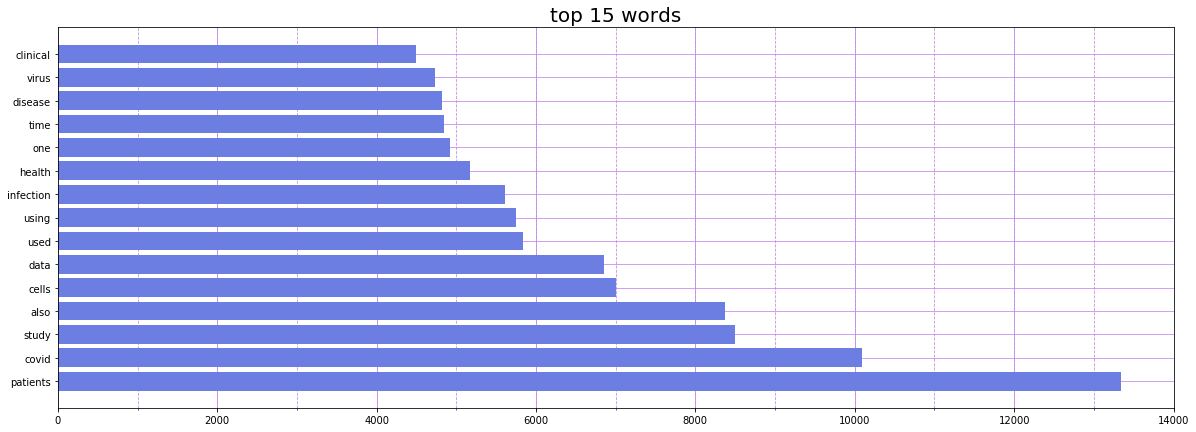

In [12]:
def top_words(sorted_list, n, title):
    
    bars = [sorted_list[i][0] for i in range(0, n)]
    values = [sorted_list[i][1] for i in range(0, n)]
    
    y = np.arange(n)
    
    fig, ax = plt.subplots(figsize=(20, int(n*0.5)))
    
    ax.grid(True, color = "#C688EB")
    ax.barh(bars, values, color = "#6C7EE1") 
    ax.set_axisbelow(True)
    ax.xaxis.set_minor_locator(MultipleLocator(1000))
    ax.grid(True, "minor", linestyle="--", color = "#C688EB")
    ax.set_title(title, fontdict = {'fontsize' : 20})

n = 15
top_words(words_counted_reduce, n, f"top {n} words")

## 2.3 Grid-seach on number of workers and number of partitions

We have run the algorithm several times by changing the number of workers and the number of partitions in order to visualize the execution time.


In [22]:
def grid_search_counts(n_partitions):

    start = time.time()
    input_bag = db.read_text("./json_singleline/*.json").map(js.loads).repartition(n_partitions)
    words_counted_map = input_bag.pluck("body_text").map(counts_of_word)
    
    words_counted_reduce = words_counted_map.flatten().foldby('word', binop=increment, 
                                      initial=0, combine = lambda x,y: x+y, 
                                      combine_initial=0).compute()
    end = time.time()
    diff = end - start
    
    print("For {} partitions, computational time: {}".format(n_partitions, diff))
    del words_counted_map
    del words_counted_reduce
    del input_bag
    return diff

In [23]:
time_matrix_counts = []

In [ ]:
n_partitions = [1, 10, 20, 50, 100, 500]

time_list = []
for part in n_partitions:
    time_list.append(grid_search_counts( part))
time_matrix_counts.append(time_list)

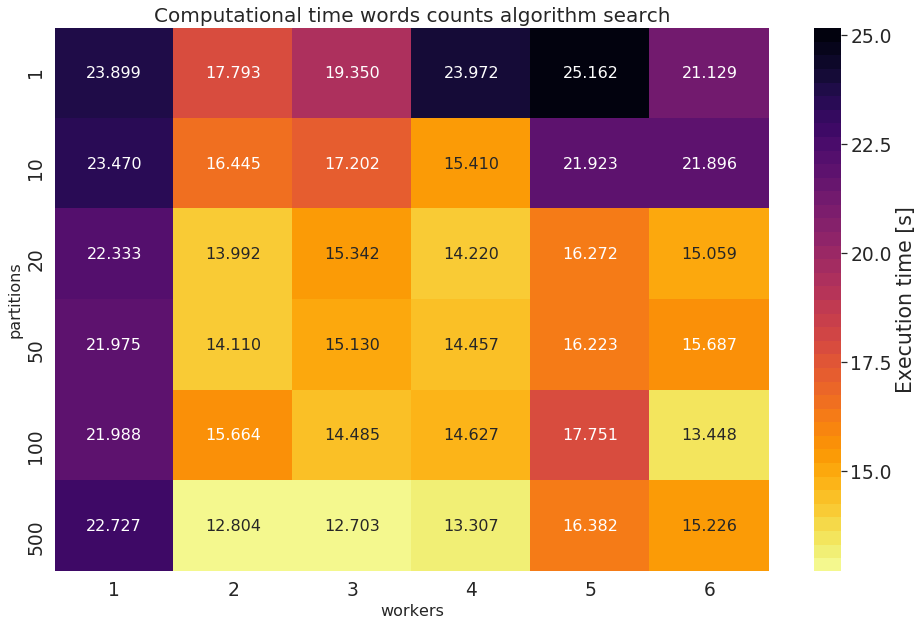

In [3]:
df_cm = pd.DataFrame(time_matrix_counts, n_partitions, [1,2,3,4,5,6])
plt.figure(figsize=(16,10))
sn.set(font_scale=1.7) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions',fontsize=16)
plt.title("Computational time words counts algorithm search",fontsize=20)
plt.show()
plt.style.use('default')

# 3 Which are the worst and best represented countries/universities in the research?

In this part we have converted each document in usable DataFrame data structure in order to figure out:
- the countries that are most and less active in the research (we have used the country of the authors)
- the universities that are most and less active in the research.

As before, we run the algorithms with different number of partitions and workers and keep track of the computational time.

## 3.1 Countries most and less active in research

In [4]:
input_bag = db.read_text("./json_singleline/*.json").map(js.loads).repartition(20)
input_bag.take(1)

({'paper_id': '00c75478b9f6b815f8b552a50fd5e20a6d10e9f4',
  'metadata': {'title': 'Journal Pre-proof Fighting COVID-19 Hypoxia with One Hand Tied Behind Our Back: Blanket Prohibition of High Flow Oxygen and Non-Invasive Positive End-Expiratory Pressure in United States Hospitals Fighting COVID-19 Hypoxia with One Hand Tied Behind Our Back: Blanket Prohibition of High Flow Oxygen and Non-Invasive Positive End-Expiratory Pressure in United States Hospitals Fighting COVID-19 Hypoxia with One Hand Tied Behind Our Back: Blanket Prohibition of High Flow Oxygen and Non-Invasive Positive End-Expiratory Pressure in United States Hospitals',
   'authors': [{'first': 'Joseph',
     'middle': [],
     'last': 'Colla',
     'suffix': '',
     'affiliation': {'laboratory': '',
      'institution': 'University of Illinois',
      'location': {'settlement': 'Chicago', 'region': 'IL', 'country': 'USA'}},
     'email': ''},
    {'first': 'Adam',
     'middle': [],
     'last': 'Rodos',
     'suffix': ''

As we can see from the structure of the JSON file, we have to:
- `pluck` in 'metadata'
- `pluck` in 'authors'
- `flatten` the results in order to get rid of the list
- `pluck` in 'affiliation'
- `filter` None values in order to get rid of the empty `dict`
- `pluck` in 'location'

In [5]:
data_country = (input_bag.pluck('metadata').pluck('authors')
                .flatten().pluck('affiliation').filter(None).pluck('location'))
data_country = data_country.to_dataframe()
data_country.head(10)

,settlement,region,country
0,Chicago,IL,USA
1,Chicago,IL,USA
2,Chicago,IL,USA
3,Athens,NaN,Greece
4,Urayasu,Chiba,Japan
5,Urayasu,Chiba,Japan
6,Urayasu,Chiba,Japan
7,Urayasu,Chiba,Japan
8,Urayasu,Chiba,Japan
9,Hamedan,NaN,Iran


In [6]:
data_country.groupby('country').size().compute().sort_values(ascending = False)[0:20]

country
China                         455
USA                           417
Italy                         207
Germany                       165
Spain                         125
France                        117
UK                            107
Brazil                         96
United States                  94
Australia                      88
Japan                          83
India                          76
Canada                         71
Sweden                         56
Iran                           47
People's Republic of China     47
The Netherlands                45
PR China                       37
Portugal                       32
Belgium                        30
dtype: int64

We can see that some countries are represented with different names, so we replace them.

After this cleaning procedure, we compute the count of the occurrence for each country using `size`.

In [7]:
list_USA = ['United States','California','United States, USA','United States, United States','USA., China','U S. A',
           'USA;','Usa','United States, France', 'US), Greece, GR), UK), US), UK), UK',  'Bulgaria, USA, USA']
list_China = ['PR China','P.R. China', 'P.R. China, PR China', 'China., China', "People's Republic of China",
              'China;', 'China aa, USA ab','China-Japan, China', "People's Republic of China., China",
             "People' s Republic of China"]
list_UK = ['UK, UK','UK', 'UK, China', 'UK A R', 'United Kingdom., United Kingdom', '7 UK','England']
list_Spain = ['España','España, Spain', 'Spain;','Spain. 19' 'Spain., Italy', 'Spain., Spain', 'Spain., Italy', 'Spain. 19']
list_Iran = ['Iran, Iran', 'Iran A R']
list_Brazil = ['Brasil. CEP','Brazil., Brazil']
list_Italy = ['Italy ; 27', 'Italy; 16', 'Italy;, Italy', 'Italy Neurological Sciences', 'Italy. (', '10 Italy',
             'Italy, Italy']
list_Germany = ['Germany, United States', 'Germany Schlüsselwörter', 'South Korea, Germany']
list_Russia = ['127051 Russia','127051 Russia', '119991 Russia']
list_Greece = ['Greece, Austria']
list_France = ['Guadeloupe, France', 'France, France, France', 'France, France', 'France, Singapore']
list_Sing = ['Singapore, Singapore']
list_Japan = ['Japan, Japan', 'JAPAN, JAPAN']
list_Austria = ['Austria Opinion', 'Austria, Austria']
list_Ireland = ['Ireland; C.OTOOLE9@nuigalway.ie (C.O.']
list_Finland = ['Finland;, Finland']

country = (data_country.replace(list_USA, 'USA').replace(list_China, 'China').
           replace(list_UK, 'United Kingdom').replace(list_Spain,'Spain').
           replace(list_Iran, 'Iran').replace(list_Brazil, 'Brazil').replace(list_Italy, 'Italy').
           replace(list_Germany, 'Germany').replace(list_Russia, 'Russia').replace(list_Greece, 'Greece').
           replace(list_France, 'France').replace(list_Sing, 'Singapore').replace(list_Japan, 'Japan').
           replace(list_Austria, 'Austria').replace(list_Ireland, 'Ireland').replace(list_Finland, 'Finland').
           groupby('country').size().compute().sort_values(ascending = False))

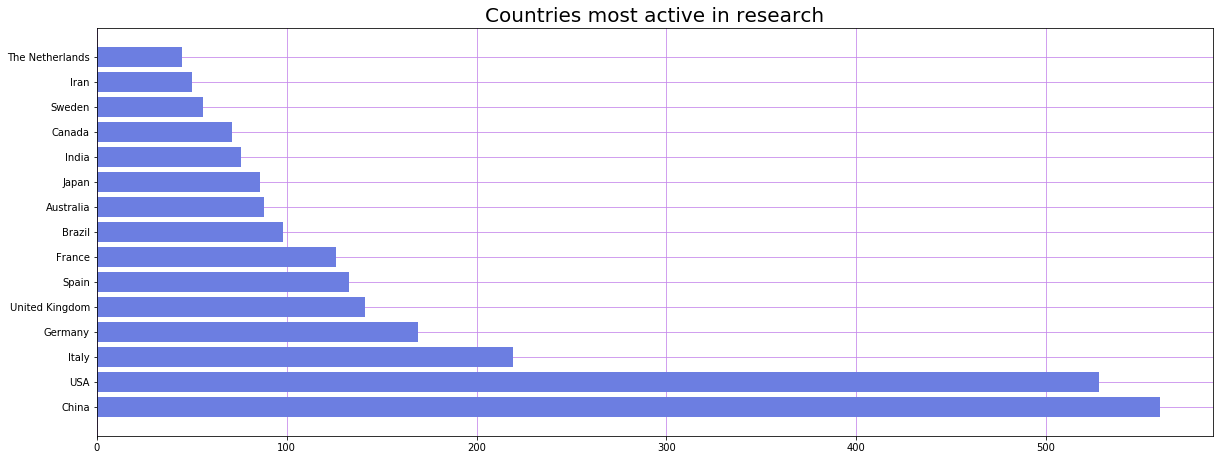

In [23]:
def top_active(sorted_list, n, title,initial_pos=0):
    
    bars = [sorted_list.index[i] for i in range(initial_pos, n)]
    values = [sorted_list[i] for i in range(initial_pos, n)]
    
    y = np.arange(len(bars))

    fig, ax = plt.subplots(figsize=(20, len(y)*0.5))
    
    ax.grid(True, color = "#C688EB")
    ax.barh(bars, values, color = "#6C7EE1") 
    ax.set_axisbelow(True)
    ax.xaxis.set_minor_locator(MultipleLocator(1000))
    ax.grid(True, "minor", linestyle="--", color = "#C688EB")
    ax.set_title(title, fontdict = {'fontsize' : 20})

# Top 15 active countries
top_active(country, 15, 'Countries most active in research')

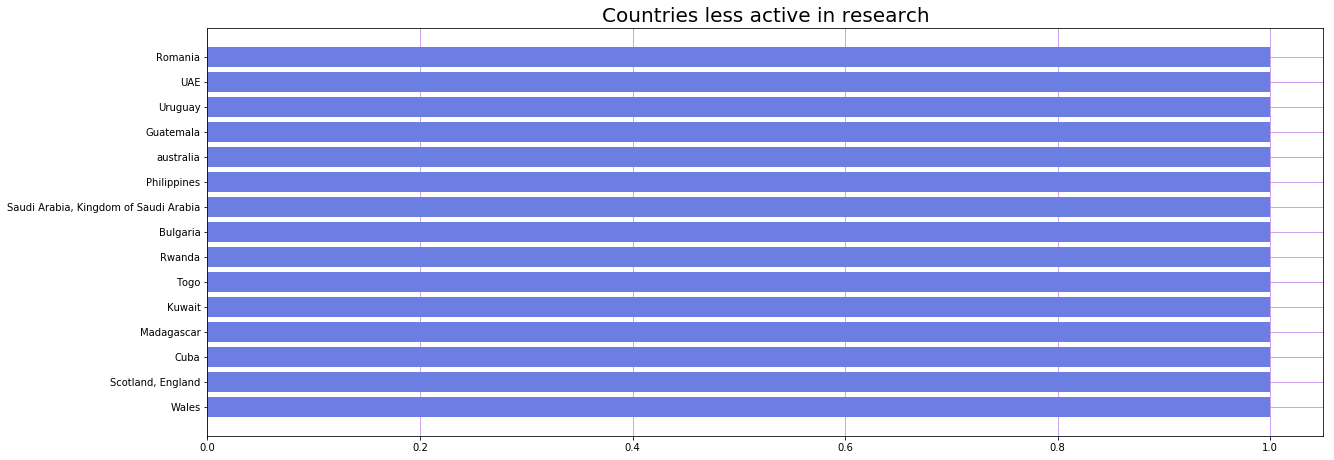

In [24]:
# Less 15 active countries
top_active(country, len(country), 'Countries less active in research', initial_pos = len(country) - 15)

## 3.2 Universities most and less active in research

In [20]:
data_univ = (input_bag.pluck('metadata').pluck('authors').
             flatten().pluck('affiliation').filter(None))
data_univ = data_univ.to_dataframe()
data_univ.head(10)

,laboratory,institution,location
0,,University of Illinois,"{'settlement': 'Chicago', 'region': 'IL', 'cou..."
1,,University of Illinois,"{'settlement': 'Chicago', 'region': 'IL', 'cou..."
2,,University of Illinois at Chicago College of M...,"{'settlement': 'Chicago', 'region': 'IL', 'cou..."
3,,University of West Attica,"{'settlement': 'Athens', 'country': 'Greece'}"
4,,Juntendo University Urayasu Hospital,"{'addrLine': '2-1-1 Tomioka', 'postCode': '279..."
5,,Juntendo University Urayasu Hospital,"{'addrLine': '2-1-1 Tomioka', 'postCode': '279..."
6,,Juntendo University Urayasu Hospital,"{'addrLine': '2-1-1 Tomioka', 'postCode': '279..."
7,,Juntendo University Urayasu Hospital,"{'addrLine': '2-1-1 Tomioka', 'postCode': '279..."
8,,Juntendo University Urayasu Hospital,"{'addrLine': '2-1-1 Tomioka', 'postCode': '279..."
9,,Bu-Ali Sina University,"{'postCode': '65178-38683', 'settlement': 'Ham..."


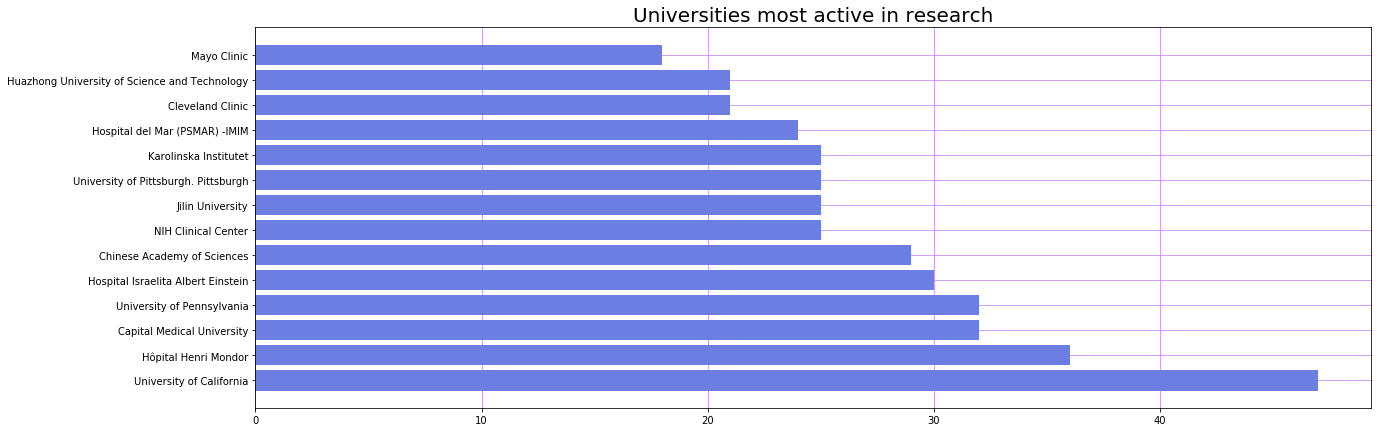

In [25]:
univ = data_univ.groupby('institution').size().compute().sort_values(ascending = False)

# Top 15 active universities
top_active(univ, 15, 'Universities most active in research',initial_pos=1)

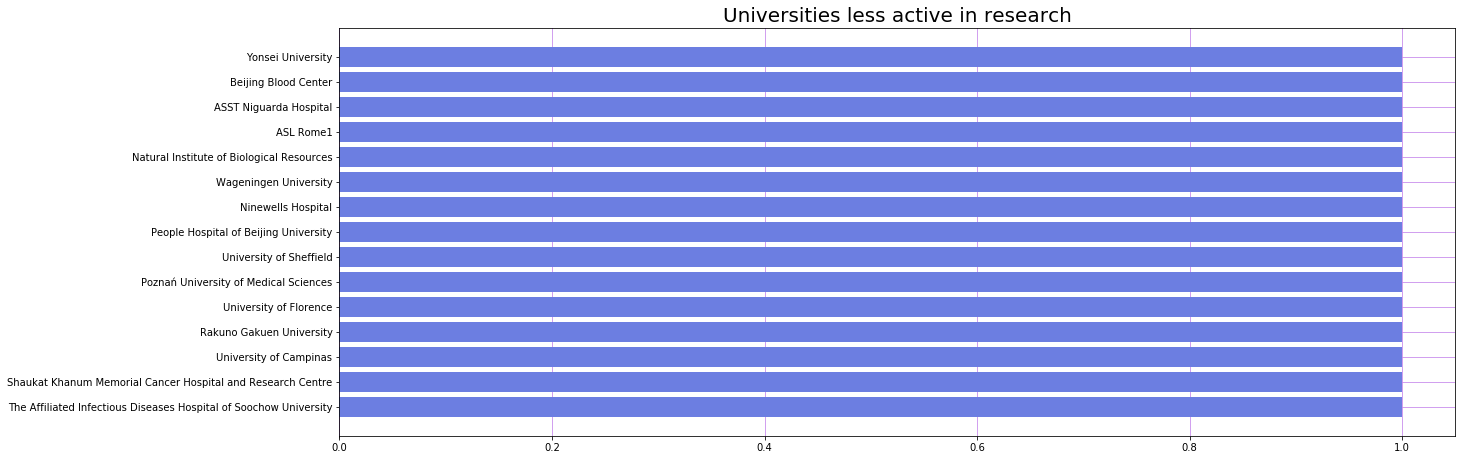

In [26]:
# Less 15 active universities
top_active(univ, len(univ), 'Universities less active in research', initial_pos = len(univ) - 15)

## 3.3 Grid-search on countries and universities with different number of partititons and workers

We have run the algorithm several times by changing the number of workers and the number of partitions in order to visualize the execution time.

In [49]:
def grid_search_countries(n_partitions):
    
    start = time.time()
    input_bag = db.read_text("./json_singleline/*.json").map(js.loads).repartition(n_partitions)
    
    
    data_country = (input_bag.pluck('metadata').pluck('authors')
                   .flatten().pluck('affiliation').filter(None).pluck('location'))
    data_country = data_country.to_dataframe()
    
    country = data_country.groupby('country').size().compute()
    
    end = time.time()
    diff = end - start
    
    print("For {} partitions, computational time: {}".format( n_partitions, diff))
    return diff

In [50]:
time_matrix_country = []

In [31]:
time_list = []
for part in n_partitions:
    time_list.append(grid_search_countries(part))
time_matrix_country.append(time_list)

For 1 partitions, computational time: 12.846150875091553
For 10 partitions, computational time: 3.831408977508545
For 20 partitions, computational time: 3.243894577026367
For 50 partitions, computational time: 3.040823459625244
For 100 partitions, computational time: 2.961162567138672
For 500 partitions, computational time: 3.3865442276000977


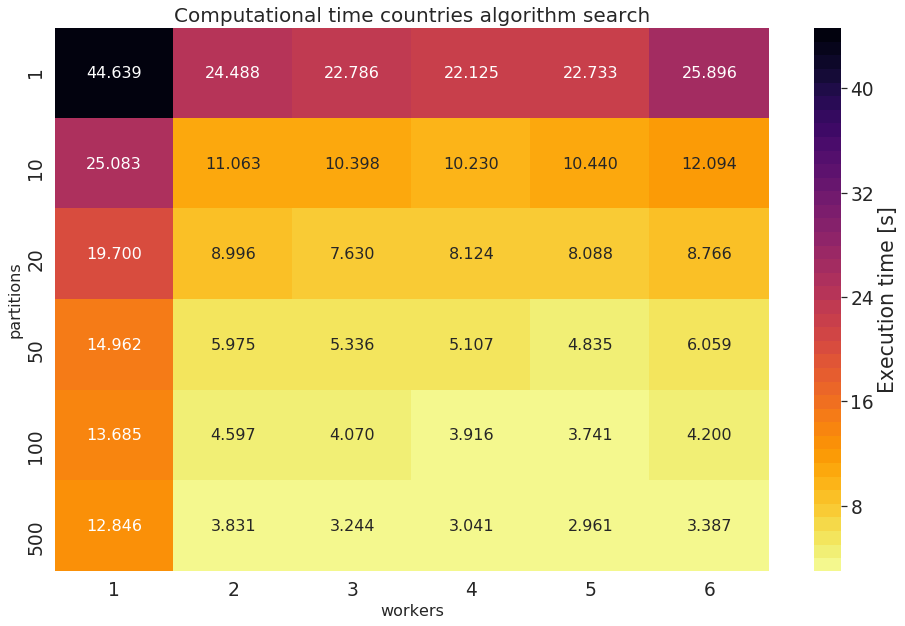

In [32]:
df_cm = pd.DataFrame(time_matrix_country, n_partitions, [1,2,3,4,5,6])
plt.figure(figsize=(16,10))
sn.set(font_scale=1.7) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions',fontsize=16)
plt.title("Computational time countries algorithm search",fontsize=20)
plt.show()
plt.style.use('default')

In [28]:
def grid_search_univ(n_partitions):

    start = time.time()
    input_bag = db.read_text("./json_singleline/*.json").map(js.loads).repartition(n_partitions)
    
    data_univ = (input_bag.pluck('metadata').pluck('authors').
                 flatten().pluck('affiliation').filter(None))
    data_univ = data_univ.to_dataframe()
    univ = data_univ.groupby('institution').size().compute()
    
    end = time.time()
    diff = end - start
    
    print("For {} partitions, computational time: {}".format( n_partitions, diff))
    
    return diff

In [31]:
time_matrix_univ=[]

In [29]:
n_partitions = [1, 10, 20, 50, 100, 500]
time_list = []
for part in n_partitions:
    time_list.append(grid_search_univ( part))
time_matrix_univ.append(time_list)

For 1 partitions, computational time: 13.863276243209839
For 20 partitions, computational time: 4.202592134475708
For 10 partitions, computational time: 4.373464822769165
For 50 partitions, computational time: 3.872154712677002
For 100 partitions, computational time: 3.624666929244995
For 500 partitions, computational time: 4.341679811477661


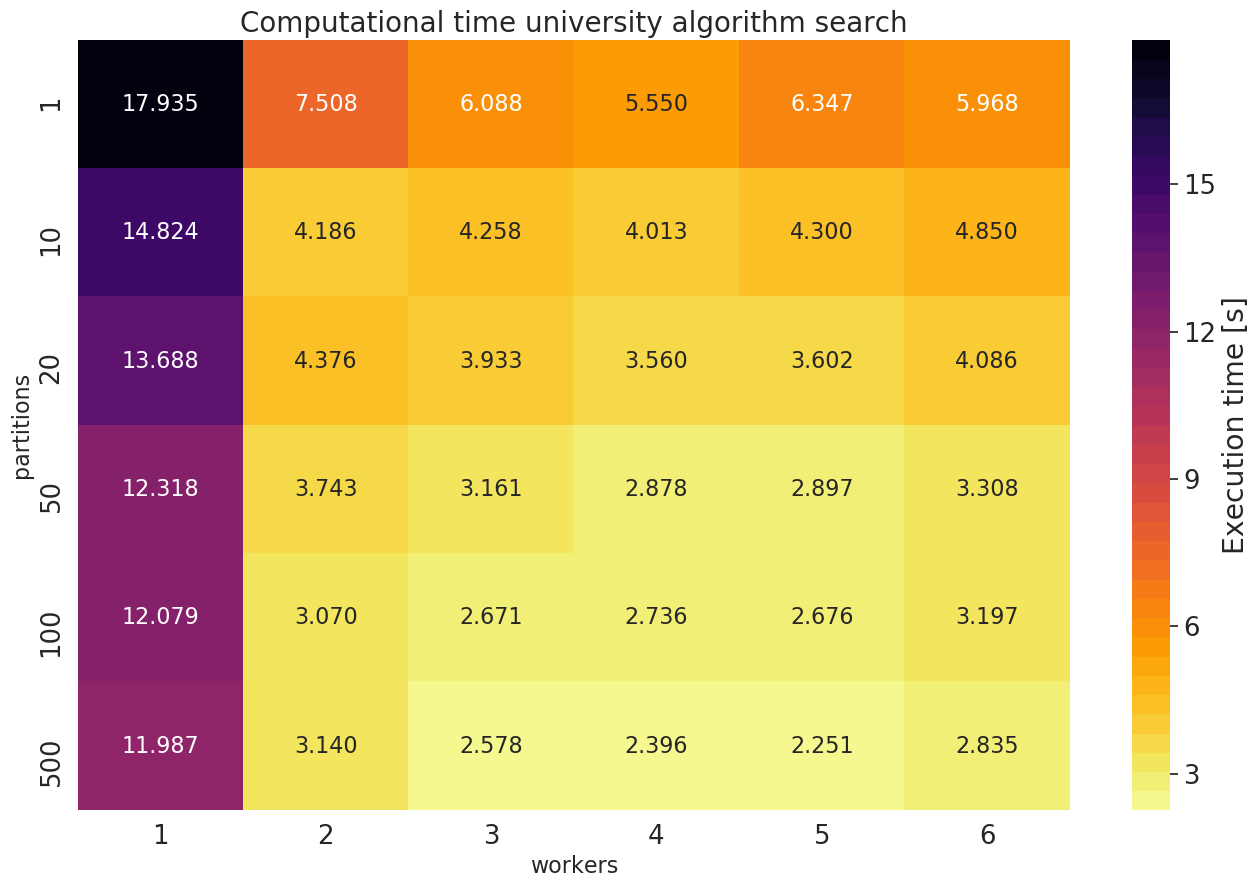

In [5]:
df_cm = pd.DataFrame(time_matrix_univ, n_partitions, [1,2,3,4,5,6])
plt.figure(figsize=(16,10))
sn.set(font_scale=1.7) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions',fontsize=16)
plt.title("Computational time university algorithm search",fontsize=20)
plt.show()
plt.style.use('default')

# 4 Embedding the title of the papers

In NLP a common technique to perform analysis over a set of texts is based on the idea to transform each of them into a set of vectors. In this scenario given a set of vectors each of them will represent a single word for the corresponding document. So at the end of the pre-processing a document will be mapped into a list of vectors or a matrix of $n \times m$ where $n$ is the number of words in the document and $m$ is the size of the vector that represents the word $n$.

In order to implement this technique we have downloaded a pre-trained model that can be found at this link: https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec. This model is a huge dictionary in the following format: $key: vector$ where the different keys ($300$) will be the "available" words.
Basically, if we have a sentence made by $5$ words (according to the model), we will have a 

matrix $5 \times 300$ featuring the sentence.

We have used the map approach to create a DataFrame
that is composed by:
- paper-id
- title-embedding

In [5]:
df = db.read_text('./json_singleline/*.json').map(js.loads)
df = df.repartition(npartitions = 100)
df.take(1)

({'paper_id': '00c75478b9f6b815f8b552a50fd5e20a6d10e9f4',
  'metadata': {'title': 'Journal Pre-proof Fighting COVID-19 Hypoxia with One Hand Tied Behind Our Back: Blanket Prohibition of High Flow Oxygen and Non-Invasive Positive End-Expiratory Pressure in United States Hospitals Fighting COVID-19 Hypoxia with One Hand Tied Behind Our Back: Blanket Prohibition of High Flow Oxygen and Non-Invasive Positive End-Expiratory Pressure in United States Hospitals Fighting COVID-19 Hypoxia with One Hand Tied Behind Our Back: Blanket Prohibition of High Flow Oxygen and Non-Invasive Positive End-Expiratory Pressure in United States Hospitals',
   'authors': [{'first': 'Joseph',
     'middle': [],
     'last': 'Colla',
     'suffix': '',
     'affiliation': {'laboratory': '',
      'institution': 'University of Illinois',
      'location': {'settlement': 'Chicago', 'region': 'IL', 'country': 'USA'}},
     'email': ''},
    {'first': 'Adam',
     'middle': [],
     'last': 'Rodos',
     'suffix': ''

In [6]:
def flatten(record):
    return {
        'id': record['paper_id'],
        'title': record['metadata']['title'].lower()
    }

df = df.map(flatten).to_dataframe()
df = df.persist()

In [7]:
df.head()

,id,title
0,00c75478b9f6b815f8b552a50fd5e20a6d10e9f4,journal pre-proof fighting covid-19 hypoxia wi...
1,00d785ead20c76504710e80ee07313c6f9c05a52,a cross-sectional population-based study on th...
2,00de656e1c8f3b13afc0f491200e3b43b907945b,the author's response
3,00f1ef126735474ccaf3a8d1cce9a4823d7f1228,a green strategy for the synthesis of sulfone ...
4,012ae149fdd6c4bcc958aab78a29bf234a8f7d93,selected approaches to the assessment of envir...


In [8]:
# Read the model
def load_vectors(fname):
    fin = io.open(fname, "r", encoding="utf-8", newline="\n", errors="ignore")
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(" ")
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

#  This function finds the embedded title
def embed(text, model):
    text = text.lower()
    text_split = text.split()
    text_list = [model[t] for t in text_split]
    text_string = [["%.8f" % n for n in emb] for emb in text_list]
        
    return text_string

# This function formats properly the title and its "embedding"
def dict_embed(text, model):
    
    return {
        "title": text,
        "emb_title": embed(text, model)
    }

In [12]:
# Import data
titles = (db.read_text('./json_singleline/*.json')
          .map(js.loads).pluck("metadata").pluck("title").compute())
model = load_vectors("wiki.en.vec")

# Clean up the title from word not "knowed" by the model
allow_words = list(model.keys())
clean_title = []
for title in titles:
    dummy_list = title.lower()
    dummy_list = dummy_list.split()
    dummy_list = [word for word in dummy_list if word in allow_words]
    dummy_list = ' '.join(dummy_list)
    clean_title.append(dummy_list)

# Get titles and embed them
titles_emb = [dict_embed(d, model) for d in clean_title]

# Save embedded paper titles in files 
for i in range(len(titles_emb)):
    fname = "./new_emb/embeddings"+str(i)+".json"
    with open (fname, 'w+') as wf:
        js.dump(titles_emb[i], wf)

In [13]:
# Load embedded papers
embedded_files = db.read_text('./new_emb/*.json')
embedded_files.take(1)

('{"title": "journal fighting hypoxia with one hand tied behind our blanket prohibition of high flow oxygen and positive pressure in united states hospitals fighting hypoxia with one hand tied behind our blanket prohibition of high flow oxygen and positive pressure in united states hospitals fighting hypoxia with one hand tied behind our blanket prohibition of high flow oxygen and positive pressure in united states hospitals", "emb_title": [["0.23255000", "-0.11983000", "-0.03462400", "0.41877000", "-0.46487000", "0.30266000", "0.13240000", "0.09440700", "0.57674000", "0.26166000", "0.27287000", "0.06578000", "-0.21011000", "-0.16715000", "-0.18214000", "-0.21855000", "0.11678000", "0.17208000", "0.16250000", "0.61699000", "-0.14899000", "0.27478000", "0.02202600", "-0.26430000", "-0.17485000", "-0.23246000", "0.30297000", "0.03983400", "0.38349000", "0.11217000", "0.16297000", "0.20791000", "-0.10912000", "0.53255000", "-0.40820000", "-0.28100000", "0.15892000", "-0.05943000", "-0.034

## 3.2 Bonus Point- Cosine Similarity
Cosine similarity is a metric which measures the similarity between two vectors.
We can try to use this tool in order to explore the realized framework based on the idea of words mappend in vectors. In particular similar words will have similar numerical representation.

According to this we will implement an algorithm that can detect if two sentences are similar (we will do it in sequential and parallel case).
We can define the cosine similarity ($\varphi(\textbf{x},\textbf{y})$) of two different vectors $\textbf{x},\textbf{y}$  in the following way: 
$$
\varphi(\textbf{x},\textbf{y}) = \dfrac{ \textbf{x} \cdot \textbf{y} }{ \sqrt{ \textbf{x} \cdot \textbf{x} \, \textbf{y} \cdot \textbf{y} } }
$$


In this cell we take in input the files saved in the previus point. They are still in `.json` format to make our work in this section easier.

Now we have to save the input file in a format which make easy the computation of $\varphi$:

In [14]:
input_emb_titles = db.read_text('./new_emb/*.json').map(js.loads)
 
def string_to_float(title):
    return np.array([[float(w) for w in word] for word in title])

def float_db(record):
    return {
        "title": record['title'],
        "embedding": string_to_float(record['emb_title'])
    }

titles_emb = db.from_sequence(input_emb_titles.map(float_db)).compute() 
print(titles_emb[1])

{'title': 'a study on the influence of the pandemic on incomes in greece', 'embedding': array([[ 1.1559e-01,  3.0192e-01, -1.1465e-01, ...,  1.1048e-01,
         1.3074e-01,  4.1164e-02],
       [ 1.5190e-01, -1.0733e-04, -6.2792e-02, ...,  8.7667e-02,
         2.8810e-02, -2.7188e-01],
       [-2.9945e-02,  8.3080e-02, -4.1043e-02, ...,  3.6366e-02,
        -4.8136e-02,  1.4706e-03],
       ...,
       [-6.6420e-02,  3.0969e-01, -8.6885e-02, ...,  2.7098e-01,
         4.1447e-01, -2.5261e-01],
       [ 1.2367e-01, -1.3965e-01,  4.4877e-02, ...,  6.4740e-02,
        -1.4581e-01,  1.6175e-01],
       [-2.9095e-01, -2.0288e-01, -8.1345e-02, ..., -4.3330e-01,
         1.4470e-01,  2.3747e-01]])}


In [15]:
# Original length of the considered list
len(titles_emb) 

998

Discard empty entries in the titles list.

In [16]:
count = 0
new_list = []
for i in range (0, len(titles_emb)):
    if (len(titles_emb[i]["embedding"]) > 0):
        new_list.append(titles_emb[i])
        count = count + 1
count

892

### 3.2.1 Serial approach

First we implement the algorithm using a serial approach.

We have $2$ indexes ($k$, $l$) running over the papers. Then we will have $2$ others indexes ($i$, $j$) running over the words/vectors in each title.

The matrix `m_3` is a matrix containing all the cosine results for $2$ titles. After the computation of `m_3`, we mean all these values and we put the mean in `final_matrix`, which is a $892 \times 892$ matrix in our case.

In [17]:
def cosine(a, b):
    dot_prod = np.dot(a.T, b.T)
    normalization = (np.dot(a.T, a.T) * np.dot(b.T, b.T))**0.5
    return dot_prod / normalization

In [18]:
n_papers = len(new_list)
final_matrix = np.zeros((n_papers, n_papers))

for k in range(0, n_papers):
    for l in range(0, k):
        
        first_index = k
        second_index = l
        
        m_1 = new_list[first_index]["embedding"]
        m_2 = new_list[second_index]["embedding"]
        m_3 = np.zeros((m_1.shape[0], m_2.shape[0]))
        
        for i in range (0, m_3.shape[0]):
            for j in range (0, m_3.shape[1]):
                
                m_3[i][j] = cosine(m_1[i][:].T, m_2[j][:].T)
                
        final_matrix[k][l] = m_3.mean()

`final_matrix` is a lower triangular matrix. The diagonal is the similarity between same title, but it is not equals to $1$ because of the mean done on `m_3`.

In [19]:
print(final_matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.25136145 0.         0.         ... 0.         0.         0.        ]
 [0.21692805 0.24009    0.         ... 0.         0.         0.        ]
 ...
 [0.20141433 0.22207867 0.23670566 ... 0.         0.         0.        ]
 [0.21284151 0.23783449 0.24229411 ... 0.21006182 0.         0.        ]
 [0.22180615 0.27085309 0.23744156 ... 0.21697991 0.24709101 0.        ]]


List of the best results in terms of compatibility:

In [20]:
result = np.where(np.logical_and(final_matrix > 0.3, final_matrix < 0.99))
listOfIndices= list(zip(result[0], result[1]))

for indice in listOfIndices:
    print(indice)

(4, 1)
(8, 1)
(8, 4)
(15, 1)
(15, 4)
(17, 4)
(18, 1)
(18, 4)
(18, 17)
(19, 1)
(22, 1)
(25, 4)
(25, 10)
(25, 17)
(25, 18)
(27, 1)
(27, 4)
(28, 1)
(28, 4)
(28, 15)
(28, 22)
(28, 25)
(28, 27)
(30, 4)
(32, 1)
(32, 22)
(36, 4)
(37, 1)
(37, 4)
(37, 15)
(37, 22)
(37, 27)
(37, 28)
(39, 1)
(39, 27)
(39, 28)
(39, 37)
(42, 1)
(42, 28)
(42, 37)
(46, 1)
(46, 4)
(46, 25)
(46, 28)
(50, 4)
(50, 15)
(50, 25)
(50, 28)
(51, 1)
(51, 4)
(51, 10)
(51, 15)
(51, 17)
(51, 18)
(51, 19)
(51, 22)
(51, 27)
(51, 28)
(51, 32)
(51, 36)
(51, 37)
(51, 39)
(51, 46)
(51, 50)
(53, 51)
(60, 4)
(60, 12)
(60, 33)
(60, 36)
(61, 60)
(63, 51)
(66, 1)
(66, 4)
(66, 15)
(66, 18)
(66, 25)
(66, 28)
(66, 37)
(66, 51)
(67, 4)
(67, 15)
(67, 28)
(67, 51)
(69, 4)
(69, 60)
(71, 1)
(71, 4)
(71, 8)
(71, 10)
(71, 15)
(71, 17)
(71, 18)
(71, 22)
(71, 25)
(71, 27)
(71, 28)
(71, 30)
(71, 32)
(71, 37)
(71, 39)
(71, 42)
(71, 46)
(71, 51)
(71, 53)
(71, 66)
(71, 67)
(74, 51)
(80, 37)
(80, 39)
(80, 71)
(82, 4)
(82, 17)
(82, 18)
(82, 25)
(82, 36)
(82,

(432, 8)
(432, 15)
(432, 18)
(432, 22)
(432, 27)
(432, 28)
(432, 37)
(432, 39)
(432, 51)
(432, 66)
(432, 71)
(432, 85)
(432, 90)
(432, 96)
(432, 104)
(432, 111)
(432, 126)
(432, 175)
(432, 182)
(432, 184)
(432, 192)
(432, 194)
(432, 208)
(432, 218)
(432, 224)
(432, 228)
(432, 230)
(432, 240)
(432, 248)
(432, 253)
(432, 266)
(432, 267)
(432, 282)
(432, 299)
(432, 315)
(432, 336)
(432, 340)
(432, 341)
(432, 348)
(432, 401)
(432, 419)
(432, 421)
(432, 424)
(433, 104)
(433, 192)
(433, 282)
(433, 321)
(434, 22)
(434, 25)
(434, 66)
(434, 90)
(434, 104)
(434, 240)
(434, 292)
(434, 319)
(434, 336)
(434, 366)
(435, 104)
(435, 321)
(436, 104)
(436, 182)
(436, 282)
(439, 1)
(439, 28)
(439, 37)
(439, 71)
(439, 104)
(439, 182)
(439, 192)
(439, 240)
(439, 267)
(439, 282)
(439, 299)
(439, 315)
(439, 336)
(439, 419)
(440, 1)
(440, 71)
(440, 104)
(440, 192)
(440, 224)
(440, 240)
(440, 282)
(440, 299)
(440, 336)
(441, 4)
(441, 18)
(441, 36)
(441, 60)
(441, 82)
(441, 97)
(441, 107)
(441, 110)
(441, 119)


(610, 85)
(610, 90)
(610, 96)
(610, 103)
(610, 104)
(610, 110)
(610, 126)
(610, 129)
(610, 134)
(610, 136)
(610, 162)
(610, 165)
(610, 182)
(610, 184)
(610, 190)
(610, 192)
(610, 194)
(610, 199)
(610, 205)
(610, 218)
(610, 224)
(610, 240)
(610, 248)
(610, 253)
(610, 259)
(610, 266)
(610, 267)
(610, 282)
(610, 299)
(610, 300)
(610, 315)
(610, 321)
(610, 336)
(610, 339)
(610, 348)
(610, 387)
(610, 390)
(610, 398)
(610, 419)
(610, 432)
(610, 457)
(610, 458)
(610, 467)
(610, 471)
(610, 475)
(610, 484)
(610, 488)
(610, 489)
(610, 491)
(610, 499)
(610, 501)
(610, 510)
(610, 514)
(610, 516)
(610, 527)
(610, 545)
(610, 550)
(610, 589)
(610, 590)
(610, 593)
(610, 608)
(611, 1)
(611, 28)
(611, 51)
(611, 71)
(611, 90)
(611, 104)
(611, 182)
(611, 240)
(611, 266)
(611, 267)
(611, 282)
(611, 299)
(611, 315)
(611, 336)
(611, 389)
(611, 419)
(611, 432)
(611, 475)
(611, 484)
(611, 488)
(611, 514)
(611, 550)
(611, 572)
(611, 589)
(611, 590)
(613, 1)
(613, 51)
(613, 71)
(613, 104)
(613, 192)
(613, 253)
(

(789, 104)
(789, 124)
(789, 491)
(789, 643)
(790, 82)
(790, 257)
(790, 321)
(790, 373)
(790, 485)
(790, 516)
(790, 582)
(790, 701)
(791, 257)
(793, 25)
(793, 28)
(793, 66)
(793, 71)
(793, 90)
(793, 104)
(793, 124)
(793, 129)
(793, 170)
(793, 175)
(793, 182)
(793, 240)
(793, 267)
(793, 282)
(793, 292)
(793, 315)
(793, 319)
(793, 321)
(793, 335)
(793, 336)
(793, 341)
(793, 348)
(793, 382)
(793, 419)
(793, 424)
(793, 432)
(793, 488)
(793, 489)
(793, 490)
(793, 491)
(793, 514)
(793, 546)
(793, 590)
(793, 593)
(793, 624)
(793, 630)
(793, 674)
(793, 703)
(793, 780)
(794, 257)
(794, 300)
(794, 321)
(794, 491)
(794, 516)
(795, 321)
(796, 36)
(796, 82)
(796, 129)
(796, 190)
(796, 257)
(796, 300)
(796, 321)
(796, 420)
(796, 485)
(796, 516)
(796, 523)
(796, 528)
(796, 566)
(796, 582)
(796, 589)
(796, 649)
(796, 701)
(797, 175)
(797, 341)
(798, 4)
(798, 36)
(798, 60)
(798, 192)
(798, 257)
(798, 321)
(798, 555)
(798, 589)
(798, 604)
(799, 25)
(799, 104)
(799, 192)
(799, 240)
(799, 257)
(799, 267)
(

Let's see some similar titles.

In [21]:
for index_1,index_2 in listOfIndices:
    if (len(new_list[index_1]["title"].split())>3 and len(new_list[index_2]["title"].split()) >3 ) :
        
        print("First: ",new_list[index_1]["title"])
        print("Second: ",new_list[index_2]["title"],'\n')

First:  the role of mucosal microbiota in the and pathologies of the mucosal immune system mucosal development and physiology of mucosal defense
Second:  a study on the influence of the pandemic on incomes in greece 

First:  journal a novel method for determination of the potential antiviral candidate for the emergency treatment of virus in human application to a study in egyptian human volunteers method for determination of the potential antiviral candidate for the emergency treatment of virus in human application to a study in a novel method for determination of the potential antiviral candidate for the emergency treatment of virus in human application to a study in egyptian human volunteers
Second:  a study on the influence of the pandemic on incomes in greece 

First:  journal a novel method for determination of the potential antiviral candidate for the emergency treatment of virus in human application to a study in egyptian human volunteers method for determination of the potenti

Second:  design of a regulatory strategy in compliance with the international and the regulation vitro diagnostic medical device 

First:  in adult patients with hematological analysis of clinical characteristics and outcomes
Second:  integrity of plasma dna is inversely correlated with antitumor immunity in ovarian cancer patients 

First:  in adult patients with hematological analysis of clinical characteristics and outcomes
Second:  sensitivity analysis of the effects of interventions on in europe 

First:  in adult patients with hematological analysis of clinical characteristics and outcomes
Second:  analysis of computed tomography helps predict poor prognostic outcome in 

First:  in adult patients with hematological analysis of clinical characteristics and outcomes
Second:  effective treatment of severe acute pancreatitis and pneumonia with 

First:  in adult patients with hematological analysis of clinical characteristics and outcomes
Second:  and correlates of neutralizing anti

First:  coronavirus disease emergency and cancer in the south of new for the
Second:  the efficacy and safety of in feeding intolerance of critically ill patients receiving a study 

First:  coronavirus disease emergency and cancer in the south of new for the
Second:  prophylaxis of with and chloroquine accepted article 

First:  coronavirus disease emergency and cancer in the south of new for the
Second:  predictive association of genetic polymorphism with the efficacy or safety of and in coronavirus patients 

First:  coronavirus disease emergency and cancer in the south of new for the
Second:  impact of the lockdown on the adherence of stroke patients to direct oral a secondary analysis from the study 

First:  coronavirus disease emergency and cancer in the south of new for the
Second:  behaviour during the pandemic among saudi a study what were the main where and on whom will the research have 

First:  coronavirus disease emergency and cancer in the south of new for the
Second:  

First:  synthesis and activity of derivatives and analogues thereof
Second:  and inhibitors of farnesyl pyrophosphate a perspective 

First:  synthesis and activity of derivatives and analogues thereof
Second:  in adult patients with hematological analysis of clinical characteristics and outcomes 

First:  synthesis and activity of derivatives and analogues thereof
Second:  spectrum of antimicrobial activity for disinfection of 

First:  synthesis and activity of derivatives and analogues thereof
Second:  molecular cloning and characterization of an reductase gene from liquorice 

First:  synthesis and activity of derivatives and analogues thereof
Second:  analysis of the positive rate of cases of nucleic acid tests in different in china 

First:  synthesis and activity of derivatives and analogues thereof
Second:  structural studies of the agonist complexed human reveals novel structural rearrangements resulting in an 

First:  synthesis and activity of derivatives and analogues there


First:  genetic hypothesis and side of in
Second:  coronavirus disease emergency and cancer in the south of new for the 

First:  genetic hypothesis and side of in
Second:  ethnic disparities in hospitalization for a cohort study in the uk 

First:  genetic hypothesis and side of in
Second:  establishment of a reference panel for the detection of antibodies 

First:  genetic hypothesis and side of in
Second:  article and efficacy of mrna vaccine in preclinical animal models 

First:  genetic hypothesis and side of in
Second:  journal prospects of nutritional interventions in the care of patients prospects of nutritional interventions in the care of patients 

First:  genetic hypothesis and side of in
Second:  synthesis and activity of derivatives and analogues thereof 

First:  genetic hypothesis and side of in
Second:  association between the pandemic and the risk for adverse pregnancy a cohort study association between the pandemic and the risk for adverse pregnancy a cohort study 


First:  initial introduction of minimally invasive using the concept in the upper mediastinum
Second:  healthcare elements of suffering in fatigue the experience of and trauma in the severely and very severely affected 

First:  initial introduction of minimally invasive using the concept in the upper mediastinum
Second:  sensitivity analysis of the effects of interventions on in europe 

First:  initial introduction of minimally invasive using the concept in the upper mediastinum
Second:  caring for the caregivers during the pandemic research the experiences and perceptions of workers during the pandemic in a qualitative study 

First:  initial introduction of minimally invasive using the concept in the upper mediastinum
Second:  the pandemic in avoiding of anaphylaxis risk while safely the world 

First:  initial introduction of minimally invasive using the concept in the upper mediastinum
Second:  potential of in vitro 

First:  initial introduction of minimally invasive using the c


First:  early forecasting of the potential risk zones of in
Second:  overcoming vaccine preferential bias in is the end of the pandemic still overcoming vaccine preferential bias in is the end of the pandemic still 

First:  early forecasting of the potential risk zones of in
Second:  electroencephalography during practical recommendations from the task force of the italian society of neurophysiology the italian league against epilepsy and the italian association of neurophysiology technologists 

First:  early forecasting of the potential risk zones of in
Second:  coronavirus disease emergency and cancer in the south of new for the 

First:  early forecasting of the potential risk zones of in
Second:  ethnic disparities in hospitalization for a cohort study in the uk 

First:  early forecasting of the potential risk zones of in
Second:  establishment of a reference panel for the detection of antibodies 

First:  early forecasting of the potential risk zones of in
Second:  journal pro

Second:  characteristic features and outcomes of severe acute respiratory syndrome found in severe acute respiratory syndrome intensive care unit patients 

First:  clinical characteristics and outcomes of breakthrough infections among vaccinated patients with systemic autoimmune rheumatic diseases
Second:  nutritional parameters associated with prognosis in ill 

First:  clinical characteristics and outcomes of breakthrough infections among vaccinated patients with systemic autoimmune rheumatic diseases
Second:  metabolically engineered stem to regulate macrophage heterogeneity in rheumatoid arthritis 

First:  clinical characteristics and outcomes of breakthrough infections among vaccinated patients with systemic autoimmune rheumatic diseases
Second:  a review in bacterial infections 

First:  clinical characteristics and outcomes of breakthrough infections among vaccinated patients with systemic autoimmune rheumatic diseases
Second:  predicting risk of transition to severe infection

Second:  etiology of acute respiratory disease in fattening pigs in finland 

First:  use of in human immunodeficiency virus infection
Second:  clinical characteristics and viral of outpatients with acute respiratory infections in huzhou of a retrospective study 

First:  use of in human immunodeficiency virus infection
Second:  clinical characteristics and outcomes of breakthrough infections among vaccinated patients with systemic autoimmune rheumatic diseases 

First:  use of in human immunodeficiency virus infection
Second:  supplemental information escaping host factor enterovirus genomic rna replication in the absence of replication organelles 

First:  of population groups with the most interactions for vaccination can substantially reduce total fatalities
Second:  and chronic the impact now and in the future the problem of and chronic disease 

First:  journal clinical description of the broad range of neurological presentations of a retrospective case series clinical descriptio

Second:  the and ends of rnas is not 

First:  mechanism of dopaminergic nerve transmission in different doses of morphine addiction and depression
Second:  the role of mucosal microbiota in the and pathologies of the mucosal immune system mucosal development and physiology of mucosal defense 

First:  mechanism of dopaminergic nerve transmission in different doses of morphine addiction and depression
Second:  effective treatment of severe acute pancreatitis and pneumonia with 

First:  mechanism of dopaminergic nerve transmission in different doses of morphine addiction and depression
Second:  and inhibitors of farnesyl pyrophosphate a perspective 

First:  mechanism of dopaminergic nerve transmission in different doses of morphine addiction and depression
Second:  exhaled aerosol increases with and risk factors of disease symptom severity 

First:  mechanism of dopaminergic nerve transmission in different doses of morphine addiction and depression
Second:  potential of in vitro 

Fir

Second:  early forecasting of the potential risk zones of in 

First:  the influence of meteorology on the spread of survival analysis of an equine influenza outbreak
Second:  an updated estimation of the risk of transmission of the novel coronavirus license 

First:  the influence of meteorology on the spread of survival analysis of an equine influenza outbreak
Second:  impact of job engagement on the quality of nursing the effect of nursing in south korean nurses 

First:  the influence of meteorology on the spread of survival analysis of an equine influenza outbreak
Second:  older experience of the a analysis of stresses and joys 

First:  the influence of meteorology on the spread of survival analysis of an equine influenza outbreak
Second:  tracking the twitter attention around the research efforts on the pandemic 

First:  the influence of meteorology on the spread of survival analysis of an equine influenza outbreak
Second:  characterizing the patterns of policies against a stud

Second:  a better understanding of social distancing 

First:  clinical potential of for assessing comparative analysis
Second:  clinical characteristics and viral of outpatients with acute respiratory infections in huzhou of a retrospective study 

First:  clinical potential of for assessing comparative analysis
Second:  evaluation of a rapid molecular algorithm for detection of pandemic influenza a virus and screening for a key oseltamivir resistance substitution in neuraminidase 

First:  clinical potential of for assessing comparative analysis
Second:  does twitter affect stock market financial sentiment analysis during a comparative study of the and the periods 

First:  clinical potential of for assessing comparative analysis
Second:  multivariate analysis to assist making in engineering optimization problems 

First:  clinical potential of for assessing comparative analysis
Second:  and responses to in south a rapid qualitative assessment 

First:  clinical potential of for asse

First:  clinical characteristics of death cases with
Second:  the sudden appearance of 

First:  clinical characteristics of death cases with
Second:  analytical and clinical evaluation of four commercial serological in hospitalized patients and ambulatory individuals 

First:  clinical characteristics of death cases with
Second:  clinical characteristics and viral of outpatients with acute respiratory infections in huzhou of a retrospective study 

First:  clinical characteristics of death cases with
Second:  older experience of the a analysis of stresses and joys 

First:  clinical characteristics of death cases with
Second:  clinical characteristics and outcomes of breakthrough infections among vaccinated patients with systemic autoimmune rheumatic diseases 

First:  clinical characteristics of death cases with
Second:  journal clinical description of the broad range of neurological presentations of a retrospective case series clinical description of the broad range of neurological 

First:  editorial the role of the laboratory in the diagnosis of gastrointestinal infections
Second:  functional contribution and targeted migration of innate lymphoid cells in inflammatory lung being at the right place at the right time 

First:  editorial the role of the laboratory in the diagnosis of gastrointestinal infections
Second:  impact of rapid detection of viral and atypical bacterial pathogens by polymerase chain reaction for patients with lower respiratory tract infection 

First:  editorial the role of the laboratory in the diagnosis of gastrointestinal infections
Second:  exhaled aerosol increases with and risk factors of disease symptom severity 

First:  editorial the role of the laboratory in the diagnosis of gastrointestinal infections
Second:  concept of immune response 

First:  editorial the role of the laboratory in the diagnosis of gastrointestinal infections
Second:  potential of in vitro 

First:  editorial the role of the laboratory in the diagnosis of gastr

First:  phylogenetic perspectives on the epidemiology and origins of sars and
Second:  coronavirus disease emergency and cancer in the south of new for the 

First:  phylogenetic perspectives on the epidemiology and origins of sars and
Second:  establishment of a reference panel for the detection of antibodies 

First:  phylogenetic perspectives on the epidemiology and origins of sars and
Second:  journal prospects of nutritional interventions in the care of patients prospects of nutritional interventions in the care of patients 

First:  phylogenetic perspectives on the epidemiology and origins of sars and
Second:  synthesis and activity of derivatives and analogues thereof 

First:  phylogenetic perspectives on the epidemiology and origins of sars and
Second:  association between the pandemic and the risk for adverse pregnancy a cohort study association between the pandemic and the risk for adverse pregnancy a cohort study 

First:  phylogenetic perspectives on the epidemiology and o

First:  high resolution analysis of respiratory virus infection in vivo
Second:  antiviral activity of against virus both in vitro and in vivo 

First:  high resolution analysis of respiratory virus infection in vivo
Second:  use of in human immunodeficiency virus infection 

First:  high resolution analysis of respiratory virus infection in vivo
Second:  role of the gene of murine coronavirus strain in hepatitis 

First:  high resolution analysis of respiratory virus infection in vivo
Second:  clinical outcomes in outpatient respiratory virus infection in immunocompromised children 

First:  high resolution analysis of respiratory virus infection in vivo
Second:  levels of and in the lungs of pneumonia patients 

First:  high resolution analysis of respiratory virus infection in vivo
Second:  editorial the role of the laboratory in the diagnosis of gastrointestinal infections 

First:  the effects of substance use on severe acute respiratory syndrome coronavirus infection risks and ou


First:  risk factors for mortality of adult patients with hospitalised in an emerging a cohort study
Second:  article a combining a biomarker and clinical factors for predicting survival of 

First:  risk factors for mortality of adult patients with hospitalised in an emerging a cohort study
Second:  caring for the caregivers during the pandemic research the experiences and perceptions of workers during the pandemic in a qualitative study 

First:  risk factors for mortality of adult patients with hospitalised in an emerging a cohort study
Second:  potential of in vitro 

First:  risk factors for mortality of adult patients with hospitalised in an emerging a cohort study
Second:  journal prospects of nutritional interventions in the care of patients prospects of nutritional interventions in the care of patients 

First:  risk factors for mortality of adult patients with hospitalised in an emerging a cohort study
Second:  association between the pandemic and the risk for adverse pregna

Second:  the and ends of rnas is not 

First:  the effect of the timing of dexamethasone administration in patients with pneumonia
Second:  the cost of getting is it time for change in the adult reconstruction fellowship application 

First:  the effect of the timing of dexamethasone administration in patients with pneumonia
Second:  more severe presentations of acute appendicitis during 

First:  the effect of the timing of dexamethasone administration in patients with pneumonia
Second:  and the saga continues 

First:  the effect of the timing of dexamethasone administration in patients with pneumonia
Second:  cytomegalovirus reactivation and mortality in patients with acute respiratory distress syndrome 

First:  the effect of the timing of dexamethasone administration in patients with pneumonia
Second:  environmental research and public health the impact of on food results of a survey 

First:  the effect of the timing of dexamethasone administration in patients with pneumonia
Seco

Second:  editorial the role of the laboratory in the diagnosis of gastrointestinal infections 

First:  the impacts of on children
Second:  phylogenetic perspectives on the epidemiology and origins of sars and 

First:  the impacts of on children
Second:  journal implications of in marine fisheries from the northwestern mediterranean sea implications of in marine fisheries from the northwestern mediterranean sea 

First:  the impacts of on children
Second:  estimation of the effective reproduction number of influenza based on weekly reports in miyazaki prefecture 

First:  the impacts of on children
Second:  scientific rationale for a approach to target the host response in order to try and reduce the numbers presenting with adult respiratory distress syndrome associated with is there a role for statins and inhibitors in the prevention and early treatment of the 

First:  the impacts of on children
Second:  impact of the pandemic on emergency medicine insights from faculty and resident

First:  socioeconomic correlates of obesity in and men and women
Second:  knowledge and attitude towards and its prevention in selected ten towns of survey 

First:  socioeconomic correlates of obesity in and men and women
Second:  epidemiological transition of in india from higher to lower hdi states and implications for prevention and control 

First:  socioeconomic correlates of obesity in and men and women
Second:  analytical and clinical evaluation of four commercial serological in hospitalized patients and ambulatory individuals 

First:  socioeconomic correlates of obesity in and men and women
Second:  older experience of the a analysis of stresses and joys 

First:  socioeconomic correlates of obesity in and men and women
Second:  evaluating the motivation of red cross health volunteers in the a study evaluating the motivation of red cross health volunteers in the a study ethics and dissemination 

First:  socioeconomic correlates of obesity in and men and women
Second:  mask s

Second:  socioeconomic correlates of obesity in and men and women 

First:  the clinical frailty estimating the prevalence of frailty in older patients hospitalised with the cope study
Second:  the fungal nature of pneumocystis 

First:  mapping the burden of diabetes in five small countries in europe and setting the agenda for health policy and strategic action open access
Second:  a study on the influence of the pandemic on incomes in greece 

First:  mapping the burden of diabetes in five small countries in europe and setting the agenda for health policy and strategic action open access
Second:  mapping the technological landscape of and vaccines 

First:  mapping the burden of diabetes in five small countries in europe and setting the agenda for health policy and strategic action open access
Second:  healthcare elements of suffering in fatigue the experience of and trauma in the severely and very severely affected 

First:  mapping the burden of diabetes in five small countries in 

First:  estimates of influenza vaccine effectiveness against influenza hospitalization in the elderly
Second:  patients in is obesity or the real 

First:  estimates of influenza vaccine effectiveness against influenza hospitalization in the elderly
Second:  prolongation in patients using chloroquine 

First:  estimates of influenza vaccine effectiveness against influenza hospitalization in the elderly
Second:  ultrasonography in the initial characterization of patients with 

First:  estimates of influenza vaccine effectiveness against influenza hospitalization in the elderly
Second:  the fungal nature of pneumocystis 

First:  estimates of influenza vaccine effectiveness against influenza hospitalization in the elderly
Second:  viral emerging challenges in developing vaccination strategies 

First:  estimates of influenza vaccine effectiveness against influenza hospitalization in the elderly
Second:  the clinical frailty estimating the prevalence of frailty in older patients hospital


First:  as a targeted immunization strategy
Second:  article a combining a biomarker and clinical factors for predicting survival of 

First:  as a targeted immunization strategy
Second:  proactive strategy to improve staff engagement 

First:  as a targeted immunization strategy
Second:  potential of in vitro 

First:  as a targeted immunization strategy
Second:  and chronic the impact now and in the future the problem of and chronic disease 

First:  as a targeted immunization strategy
Second:  a protocol for a systematic review and 

First:  as a targeted immunization strategy
Second:  therapy for a feasibility study 

First:  as a targeted immunization strategy
Second:  no time to repurposing of generic drugs as a multifaceted strategy against 

First:  as a targeted immunization strategy
Second:  characterizing the patterns of policies against a study characterizing the patterns of policies against a study 

First:  as a targeted immunization strategy
Second:  antiviral strategie

First:  intensive care medicine enzyme activity in serum and lavage fluid after damage to the barrier in the human lung
Second:  the role of mucosal microbiota in the and pathologies of the mucosal immune system mucosal development and physiology of mucosal defense 

First:  intensive care medicine enzyme activity in serum and lavage fluid after damage to the barrier in the human lung
Second:  healthcare elements of suffering in fatigue the experience of and trauma in the severely and very severely affected 

First:  intensive care medicine enzyme activity in serum and lavage fluid after damage to the barrier in the human lung
Second:  potential of in vitro 

First:  intensive care medicine enzyme activity in serum and lavage fluid after damage to the barrier in the human lung
Second:  bacterial and the deadly trio in 

First:  intensive care medicine enzyme activity in serum and lavage fluid after damage to the barrier in the human lung
Second:  and prognostic significance in 

First:

First:  the home bias and the local a survey
Second:  modulation of olfactory signal detection in the olfactory focus on the internal and external and the emerging role of the immune system 

First:  the home bias and the local a survey
Second:  and prognostic significance in 

First:  the home bias and the local a survey
Second:  the future of medical scribes documenting in the electronic health results of an expert consensus conference 

First:  the home bias and the local a survey
Second:  and chronic the impact now and in the future the problem of and chronic disease 

First:  the home bias and the local a survey
Second:  from ego to for ontology in the 

First:  the home bias and the local a survey
Second:  the sudden appearance of 

First:  the home bias and the local a survey
Second:  initial introduction of minimally invasive using the concept in the upper mediastinum 

First:  the home bias and the local a survey
Second:  school of population and global the university of evide

First:  quantitative comparison of the efficiency of antibodies against and subunit of sars coronavirus spike protein in virus neutralization and blocking of receptor implications for the functional roles of subunit q
Second:  the and ends of rnas is not 

First:  quantitative comparison of the efficiency of antibodies against and subunit of sars coronavirus spike protein in virus neutralization and blocking of receptor implications for the functional roles of subunit q
Second:  recent advancements in the and prospective drug therapy of 

First:  quantitative comparison of the efficiency of antibodies against and subunit of sars coronavirus spike protein in virus neutralization and blocking of receptor implications for the functional roles of subunit q
Second:  role of the gene of murine coronavirus strain in hepatitis 

First:  quantitative comparison of the efficiency of antibodies against and subunit of sars coronavirus spike protein in virus neutralization and blocking of receptor 


First:  factor influences for diagnosis and vaccination of avian infectious bronchitis virus in chickens
Second:  clinical and risk factors for mortality in hospitalized patients with and cancer a propensity study 

First:  evolution of a cohort of infection suspects from primary health care
Second:  journal prospects of nutritional interventions in the care of patients prospects of nutritional interventions in the care of patients 

First:  evolution of a cohort of infection suspects from primary health care
Second:  and chronic the impact now and in the future the problem of and chronic disease 

First:  evolution of a cohort of infection suspects from primary health care
Second:  the sudden appearance of 

First:  evolution of a cohort of infection suspects from primary health care
Second:  levels of and in the lungs of pneumonia patients 

First:  evolution of a cohort of infection suspects from primary health care
Second:  editorial the role of the laboratory in the diagnosis of 

Second:  the effect of the timing of dexamethasone administration in patients with pneumonia 

First:  performance and health economic evaluation of the mount sinai serological assay identifies modification of as necessary to maximise specificity of the assay
Second:  the impacts of on children 

First:  performance and health economic evaluation of the mount sinai serological assay identifies modification of as necessary to maximise specificity of the assay
Second:  ultrasonography in the initial characterization of patients with 

First:  performance and health economic evaluation of the mount sinai serological assay identifies modification of as necessary to maximise specificity of the assay
Second:  the fungal nature of pneumocystis 

First:  performance and health economic evaluation of the mount sinai serological assay identifies modification of as necessary to maximise specificity of the assay
Second:  development of rapid systematic survey of current practices and methods 

Fir

### 3.2.2 Parallel approach

In [22]:
results = []
start_parallel = time.time()

n_papers = 20

for k in range(0, n_papers):
    for l in range(0, k + 1):
        
        first_index = k
        second_index = l

        m_1 = new_list[first_index]["embedding"]
        m_2 = new_list[second_index]["embedding"]
        
        m_3 = []
        
        for i in range (0, len(m_2)):
            for j in range (0, len(m_1)):
                
                res = client.submit(cosine, m_1[j], m_2[i])
                m_3.append(res)
        m = client.submit(np.mean, m_3)
        results.append(m)
        
final_matrix_parallel = client.gather(results)
end_parallel = time.time()
diff_parallel = end_parallel - start_parallel

### 3.3.3 Comparison between serial and parallel approach
Comparison between serial and parallel approach using only $20$ papers.

In [23]:
n_papers = 20
final_matrix = np.zeros((n_papers, n_papers))

start_serial = time.time()

for k in range(0,n_papers):
    for l in range(0,k+1):
        
        first_index = k
        second_index = l
        
        m_1 = new_list[first_index]["embedding"]
        m_2 = new_list[second_index]["embedding"]
        m_3 = np.zeros((m_1.shape[0], m_2.shape[0]))
        
        for i in range (0, m_3.shape[0]):
            for j in range (0, m_3.shape[1]):
                
                m_3[i][j] = cosine(m_1[i][:].T, m_2[j][:].T)
                
        final_matrix[k][l] = m_3.mean()
        
end_serial = time.time()
diff_serial = end_serial - start_serial

In [24]:
print(f'Computational time using parallel approach: {diff_parallel}')
print(f'Computational time using serial approach: {diff_serial}')

Computational time using parallel approach: 128.90721130371094
Computational time using serial approach: 0.4584038257598877


Parallel approach is considerably slower than serial approach

# Appendix

## Performance in the string splitting

To split `string` we can use two different functions: 
- `string.split()` (this is an attribute of the string class).
- `word_tokenize(string)` from the `nltk` library.

in the two cells below we study the performance with one document. 

In [33]:
input_bag = db.read_text("./json_singleline/*.json").map(js.loads).repartition(20)

def body_merge(record):
    txt=''
    for reco in record:
        txt+=reco['text']
    return txt

text_bag = input_bag.pluck("body_text").map(body_merge)
string = text_bag.take(1)[0]
string = string.lower()    
remove_symbols ="1 2 3 4 5 6 9 8 7 0 . / * - + ! ' ? ^ } @ #° § ] { [ ) ( = !  £ $ % & / < > \ | , ; . : - _ < >"
remove_symbols = remove_symbols.split()
for symbol in remove_symbols:
    string = string.replace(symbol,"")

In [34]:
%timeit string.split()

15.1 µs ± 97.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
%timeit word_tokenize(string)

1.42 ms ± 6.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Grid-search for number of workers and partitions

In [1]:
from dask.distributed import Client,LocalCluster,SSHCluster    
import dask.bag as db
import numpy as np
import dask as d
import dask.dataframe as dd
import json as js
from nltk.corpus import stopwords
from nltk import word_tokenize
import os, re, io
import time
import glob as gl
from datetime import timedelta
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# If run multiple times set this variable to True  
WARM_START = True
n_partitions = [1, 10, 20, 50, 100, 500]

/root/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/root/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict
/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecat

In [2]:
if WARM_START:
    time_matrix_univ    = np.load("./univ.npy")
    time_matrix_counts  = np.load("./counts.npy")
    time_matrix_country = np.load("./country.npy")
    
else:
    time_matrix_univ    = []
    time_matrix_counts  = []
    time_matrix_country = []

In [3]:
def increment(tot, x):
    return tot + x['n_counts']
def counts_of_word(body_text):
    

    ##  Begin clean phase
    string = ''
    for txt in body_text:
        string += txt["text"]
        
    # Now we have the string which contains the full body text of the documents in input, we "lower" it  
    string = string.lower()
    
    # We need to clean it up from the stop words and 1,2,3,4,5,6,7,8,9,0,?,^,:,.,-,_,!,",£,$,%,&,/,(,),=,?<,> and ,
    remove_symbols ="1 2 3 4 5 6 9 8 7 0 . / * - + ! ' ? ^ } @ #° § ] { [ ` ) ( = !  £ $ % & / < > \ | , ; . : - _ < >"
    remove_symbols = remove_symbols.split()
    
    for symbol in remove_symbols:
        string = string.replace(symbol,"")
    
    # The last symbol to clean is the ", because we use it to create the string remove_symbols
    string = string.replace('"',"")
    # We have run the algorithm and we found out that some useless words appeare (also the alphabet)
    # however we remove it now 
    remove_words = stopwords.words("english") + ["et","al","may","figure","results","however","fig"]
    remove_words += "q w e r t y u i o p l k j h g f d s a z x c v b n m".split()
    string = string.split()
    
    string = [word for word in string if not word in remove_words]
    
    ## End clean phase
    
    ## Count phase
    # In this phase we count the single words using the numpy function unique
    
    words,counts = np.unique(string,return_counts=True)
    ## The Output will be the follow : [(word1,frequencies1)...(wordn,frequenciesn)]
    return [{"word":i , "n_counts": j} for i,j in zip(words,counts)]



In [29]:
client = Client("tcp://10.67.22.115:8786")

In [30]:
client

<Client: 'tcp://10.67.22.115:8786' processes=6 threads=24, memory=45.83 GiB>

In [92]:
def grid_search_counts(n_partitions):

    start = time.time()
    input_bag = db.read_text("../json_singleline/*.json").map(js.loads).repartition(n_partitions)
    words_counted_map = input_bag.pluck("body_text").map(counts_of_word)
    
    words_counted_reduce = words_counted_map.flatten().foldby('word', binop=increment, 
                                      initial=0, combine = lambda x,y: x+y, 
                                      combine_initial=0).compute()
    end = time.time()
    diff = end - start
    
    print("For {} partitions, computational time: {}".format( n_partitions, diff))
    del words_counted_map
    del words_counted_reduce
    del input_bag
    return diff

In [93]:
time_list = []
for part in n_partitions:
    time_list.append(grid_search_counts(part))
time_matrix_counts.append(time_list)

For 1 partitions, computational time: 22.727080821990967
For 10 partitions, computational time: 12.804254293441772
For 20 partitions, computational time: 12.70289945602417
For 50 partitions, computational time: 13.307487487792969
For 100 partitions, computational time: 16.382213354110718
For 500 partitions, computational time: 15.22591257095337


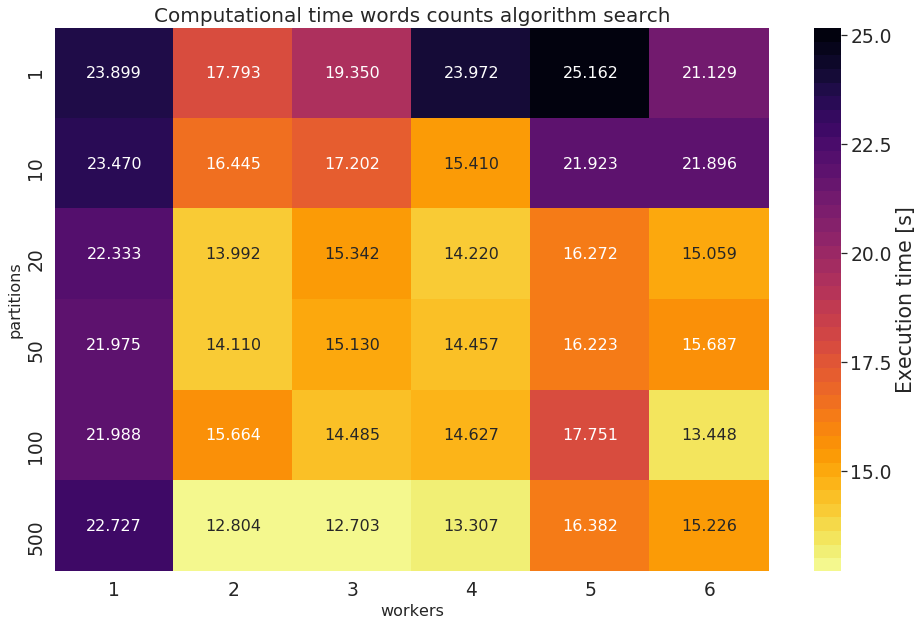

In [3]:
df_cm = pd.DataFrame(time_matrix_counts, n_partitions, [1,2,3,4,5,6])
plt.figure(figsize=(16,10))
sn.set(font_scale=1.7) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions',fontsize=16)
plt.title("Computational time words counts algorithm search",fontsize=20)
plt.show()
plt.style.use('default')

In [5]:
def grid_search_countries(n_partitions):
    
    start = time.time()
    input_bag = db.read_text("../json_singleline/*.json").map(js.loads).repartition(n_partitions)
    
    
    data_country = (input_bag.pluck("metadata").pluck('authors')
                   .flatten().pluck('affiliation').filter(None).pluck('location'))
    data_country = data_country.to_dataframe()
    
    country = data_country.groupby('country').size().compute()
    
    end = time.time()
    diff = end - start
    
    print("For {} partitions, computational time: {}".format( n_partitions, diff))
    return diff

In [31]:
time_list = []
for part in n_partitions:
    time_list.append(grid_search_countries(part))
time_matrix_country.append(time_list)

For 1 partitions, computational time: 12.846150875091553
For 10 partitions, computational time: 3.831408977508545
For 20 partitions, computational time: 3.243894577026367
For 50 partitions, computational time: 3.040823459625244
For 100 partitions, computational time: 2.961162567138672
For 500 partitions, computational time: 3.3865442276000977


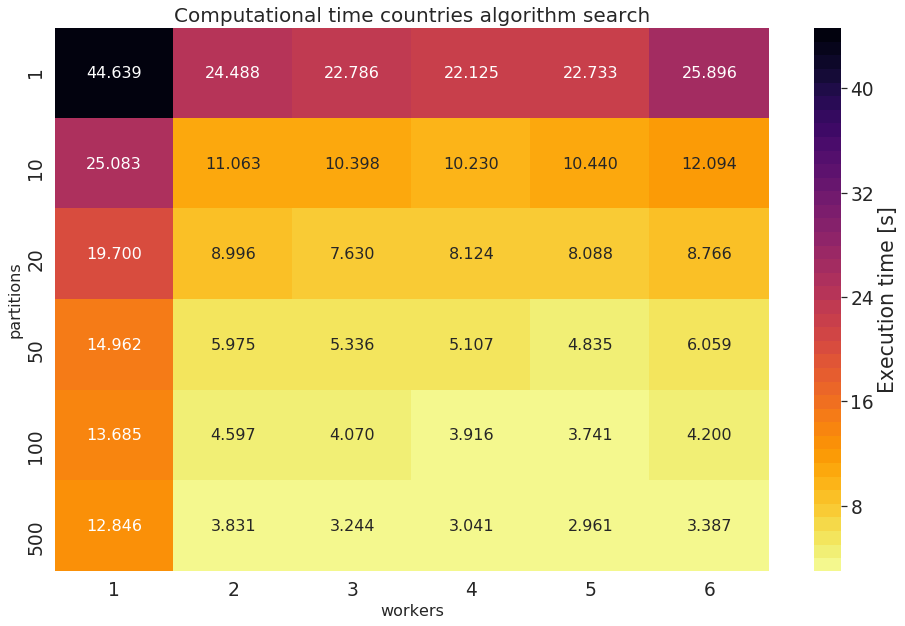

In [32]:
df_cm = pd.DataFrame(time_matrix_country, n_partitions, [1,2,3,4,5,6])
plt.figure(figsize=(16,10))
sn.set(font_scale=1.7) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions',fontsize=16)
plt.title("Computational time countries algorithm search",fontsize=20)
plt.show()
plt.style.use('default')

In [96]:
def grid_search_univ(n_partitions):

    start = time.time()
    input_bag = db.read_text("../json_singleline/*.json").map(js.loads).repartition(n_partitions)
    
    data_univ = (input_bag.pluck('metadata').pluck('authors').
                 flatten().pluck('affiliation').filter(None))
    data_univ = data_univ.to_dataframe()
    univ = data_univ.groupby('institution').size().compute()
    
    end = time.time()
    diff = end - start
    
    print("For {} partitions, computational time: {}".format( n_partitions, diff))
    
    return diff

In [97]:
time_list = []
for part in n_partitions:
    time_list.append(grid_search_univ( part))
time_matrix_univ.append(time_list)

For 1 partitions, computational time: 11.986531019210815
For 10 partitions, computational time: 3.139528274536133
For 20 partitions, computational time: 2.5777668952941895
For 50 partitions, computational time: 2.3963794708251953
For 100 partitions, computational time: 2.2514843940734863
For 500 partitions, computational time: 2.835209608078003


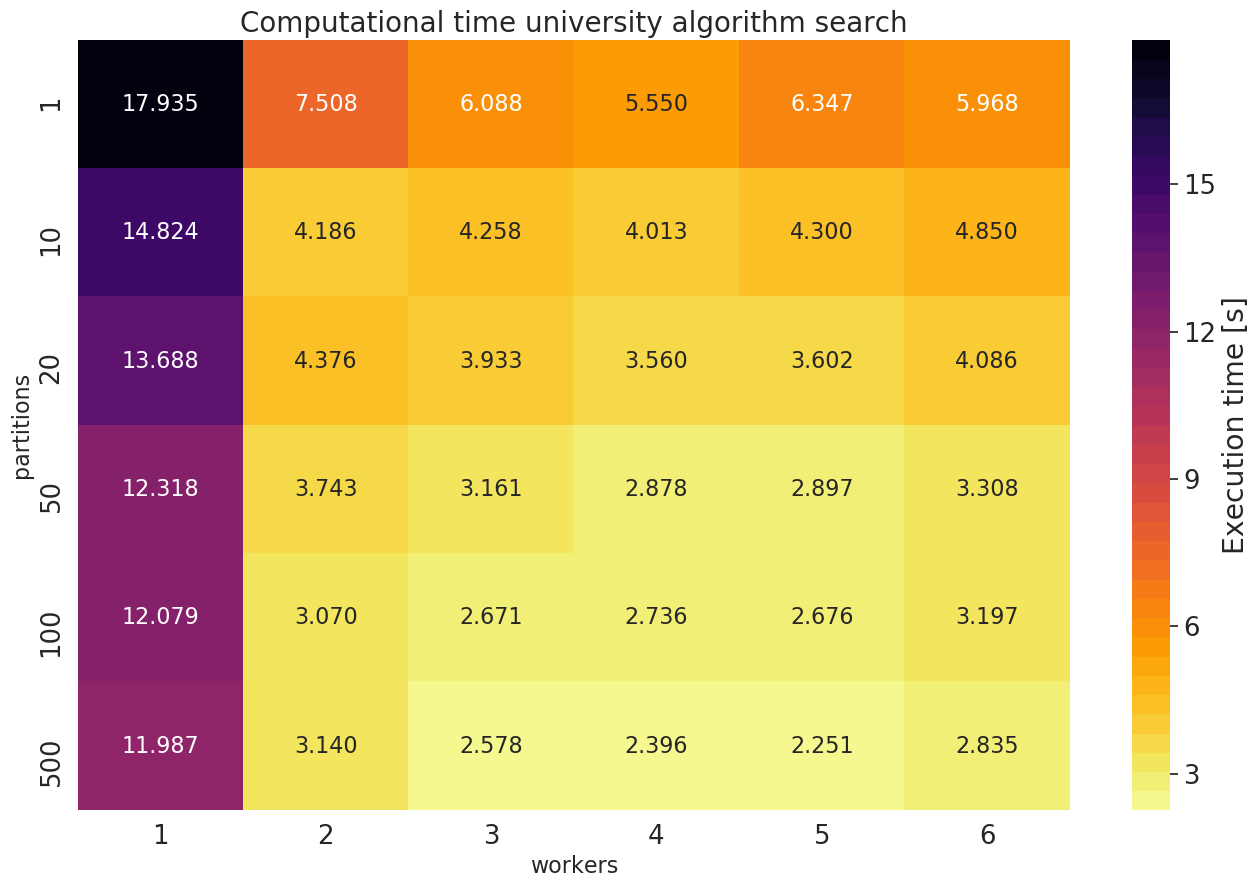

In [5]:
df_cm = pd.DataFrame(time_matrix_univ, n_partitions, [1,2,3,4,5,6])
plt.figure(figsize=(16,10))
sn.set(font_scale=1.7) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions',fontsize=16)
plt.title("Computational time university algorithm search",fontsize=20)
plt.show()
plt.style.use('default')

In [33]:
np.save("counts", time_matrix_counts)
np.save("univ",time_matrix_univ)
np.save("country",time_matrix_country)